# Model training
Pytorch tutorial: [optimization_tutorial](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html)

## Prerequisite Code

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import numpy as np
import os
from torchsummary import summary

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

num_workers = os.cpu_count()
print(f"num_workers = {num_workers} cores")

Using cuda device
num_workers = 2 cores


In [ ]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

batch_size=64
# train_dataloader = DataLoader(training_data, batch_size=batch_size,num_workers=num_workers)
# test_dataloader = DataLoader(test_data, batch_size=batch_size,num_workers=num_workers)

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

100%|██████████| 26421880/26421880 [00:08<00:00, 3003781.40it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 176659.54it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3288077.97it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 23242494.07it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
im,label=training_data.__getitem__(0)
print(im.shape)
print(label)

torch.Size([1, 28, 28])
9


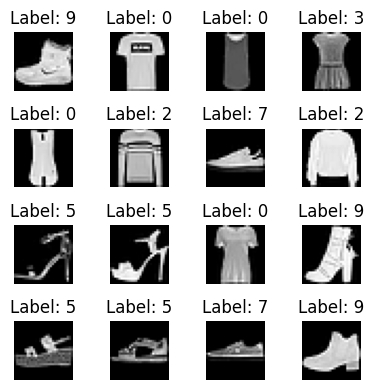

In [ ]:
# prompt: show 16 image from training_data using 4*4 grid

import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 4, figsize=(4, 4))
for i in range(16):
    row = i // 4
    col = i % 4
    im, label = training_data.__getitem__(i)
    axes[row, col].imshow(im.squeeze(), cmap='gray')
    axes[row, col].set_title(f"Label: {label}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
class CNNNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 16, kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3,padding=1),
            nn.ReLU(),
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(8*7*7, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        out = self.fc(x)
        return out

In [ ]:
model = CNNNetwork()
model.to(device)
print(model)

CNNNetwork(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Sequential(
    (0): Linear(in_features=392, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


## Hyperparameters

## Optimization Loop

In [ ]:
# Training loop (1 epoch)
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [ ]:
# Testing loop
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
#Loss function
loss_fn = nn.CrossEntropyLoss()

#Optimizer
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#Epochs
epochs = 5

In [ ]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.296554  [   64/60000]
loss: 0.696112  [ 6464/60000]
loss: 0.432653  [12864/60000]
loss: 0.573930  [19264/60000]
loss: 0.516610  [25664/60000]
loss: 0.521558  [32064/60000]
loss: 0.446924  [38464/60000]
loss: 0.592510  [44864/60000]
loss: 0.503658  [51264/60000]
loss: 0.463730  [57664/60000]
Test Error: 
 Accuracy: 84.6%, Avg loss: 0.419206 

Epoch 2
-------------------------------
loss: 0.324251  [   64/60000]
loss: 0.360497  [ 6464/60000]
loss: 0.254586  [12864/60000]
loss: 0.466877  [19264/60000]
loss: 0.374886  [25664/60000]
loss: 0.378020  [32064/60000]
loss: 0.325616  [38464/60000]
loss: 0.506948  [44864/60000]
loss: 0.407455  [51264/60000]
loss: 0.401679  [57664/60000]
Test Error: 
 Accuracy: 86.1%, Avg loss: 0.364885 

Epoch 3
-------------------------------
loss: 0.256377  [   64/60000]
loss: 0.295659  [ 6464/60000]
loss: 0.215824  [12864/60000]
loss: 0.343126  [19264/60000]
loss: 0.365402  [25664/60000]
loss: 0.363031  [32064/600

# Workshop13 image classification
data: [https://drive.google.com/file/d/1yCH8zIGo9KjdscRfrvpR1R7mel4uq1GH/view?usp=drive_link](https://drive.google.com/file/d/1yCH8zIGo9KjdscRfrvpR1R7mel4uq1GH/view?usp=drive_link)

สร้างโมเดล และทำการฝึกโมเดลเพื่อทำนาย (วินิจฉัย) จากภาพเอกซเรย์ ฟร้อมวัดประสิทธิภาพ

(พิเศษ) เพิ่มการป้องกัน overfitting ด้วยเทคนิค early stopping โดยพิจารณาจาก validation loss หาก validation loss เพิ่มขึ้นเกินจำนวน epoch ที่กำหนดให้หยุดฝึกโมเดล

In [ ]:
# !gdown 1yCH8zIGo9KjdscRfrvpR1R7mel4uq1GH

Downloading...
From (original): https://drive.google.com/uc?id=1yCH8zIGo9KjdscRfrvpR1R7mel4uq1GH
From (redirected): https://drive.google.com/uc?id=1yCH8zIGo9KjdscRfrvpR1R7mel4uq1GH&confirm=t&uuid=1417206b-f644-458a-9441-879f69fe6367
To: /content/Small_Data_CoV2.zip
100% 123M/123M [00:00<00:00, 177MB/s]


In [ ]:
# !unzip Small_Data_CoV2.zip

Archive:  Small_Data_CoV2.zip
   creating: Small_Data_CoV2_val/
   creating: Small_Data_CoV2_val/Covid/
   creating: Small_Data_CoV2_val/Covid/Patient (10)/
  inflating: Small_Data_CoV2_val/Covid/Patient (10)/Anota‡ֶo 2020-04-28 132320.png  
  inflating: Small_Data_CoV2_val/Covid/Patient (10)/Anota‡ֶo 2020-04-28 132449.png  
  inflating: Small_Data_CoV2_val/Covid/Patient (10)/Anota‡ֶo 2020-04-28 132516.png  
  inflating: Small_Data_CoV2_val/Covid/Patient (10)/Anota‡ֶo 2020-04-28 132540.png  
  inflating: Small_Data_CoV2_val/Covid/Patient (10)/Anota‡ֶo 2020-04-28 132608.png  
  inflating: Small_Data_CoV2_val/Covid/Patient (10)/Anota‡ֶo 2020-04-28 132636.png  
  inflating: Small_Data_CoV2_val/Covid/Patient (10)/Anota‡ֶo 2020-04-28 132704.png  
  inflating: Small_Data_CoV2_val/Covid/Patient (10)/Anota‡ֶo 2020-04-28 132740.png  
  inflating: Small_Data_CoV2_val/Covid/Patient (10)/Anota‡ֶo 2020-04-28 132814.png  
  inflating: Small_Data_CoV2_val/Covid/Patient (10)/Anota‡ֶo 2020-04-28 132844

In [ ]:
class CustomImageDataset(Dataset):
  def __init__(self, image_paths, labels, transform=None):
    self.image_paths = image_paths
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    image = Image.open(self.image_paths[idx]).convert('RGB')
    label = self.labels[idx]

    if self.transform:
      image = self.transform(image)

    return image, label

In [ ]:
df_dic = {}
for folder in ['Small_Data_CoV2_train', 'Small_Data_CoV2_test', 'Small_Data_CoV2_val']:
  filename = []
  label = []
  for dirname, _, filenames in os.walk(f'/content/{folder}'):
    for file in filenames:
      f = os.path.join(dirname, file)
      if '.png' in f:
        filename.append(f)
        label.append(dirname.split('/')[3])
  df_dic[folder.split('_')[3]] = pd.DataFrame({'filename':filename, 'label':label})
df_dic['train'].head()

,filename,label
0,/content/Small_Data_CoV2_train/Healthy/Patient...,Healthy
1,/content/Small_Data_CoV2_train/Healthy/Patient...,Healthy
2,/content/Small_Data_CoV2_train/Healthy/Patient...,Healthy
3,/content/Small_Data_CoV2_train/Healthy/Patient...,Healthy
4,/content/Small_Data_CoV2_train/Healthy/Patient...,Healthy


In [ ]:
le = LabelEncoder()
df_dic['train']['label'] = le.fit_transform(df_dic['train']['label'])
df_dic['test']['label'] = le.fit_transform(df_dic['test']['label'])
df_dic['val']['label'] = le.fit_transform(df_dic['val']['label'])

In [ ]:
df_dic['train'].shape, df_dic['test'].shape, df_dic['val'].shape

((597, 2), (275, 2), (284, 2))

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
train_dataset = CustomImageDataset(df_dic['train']['filename'], df_dic['train']['label'], transform=transform)
test_dataset = CustomImageDataset(df_dic['test']['filename'], df_dic['test']['label'], transform=transform)
val_dataset = CustomImageDataset(df_dic['val']['filename'], df_dic['val']['label'], transform=transform)

In [ ]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)

In [ ]:
conv = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(256, 512, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(512, 512, kernel_size=3, padding=1),
    nn.ReLU(),
)

conv.to(device)
summary(conv, input_size=(3, 224, 224), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4        [-1, 128, 112, 112]          73,856
              ReLU-5        [-1, 128, 112, 112]               0
         MaxPool2d-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 256, 56, 56]         295,168
              ReLU-8          [-1, 256, 56, 56]               0
         MaxPool2d-9          [-1, 256, 28, 28]               0
           Conv2d-10          [-1, 512, 28, 28]       1,180,160
             ReLU-11          [-1, 512, 28, 28]               0
        MaxPool2d-12          [-1, 512, 14, 14]               0
           Conv2d-13          [-1, 512, 14, 14]       2,359,808
             ReLU-14          [-1, 512,

In [ ]:
class CNNNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.ReLU(),
    )
    self.flatten = nn.Flatten()
    self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512*14*14, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 3)
        )

  def forward(self, x):
    x = self.conv(x)
    x = self.flatten(x)
    out = self.fc(x)
    return out

In [ ]:
model = CNNNetwork()
model.to(device)
summary(model, input_size=(3, 224, 224), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4        [-1, 128, 112, 112]          73,856
              ReLU-5        [-1, 128, 112, 112]               0
         MaxPool2d-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 256, 56, 56]         295,168
              ReLU-8          [-1, 256, 56, 56]               0
         MaxPool2d-9          [-1, 256, 28, 28]               0
           Conv2d-10          [-1, 512, 28, 28]       1,180,160
             ReLU-11          [-1, 512, 28, 28]               0
        MaxPool2d-12          [-1, 512, 14, 14]               0
           Conv2d-13          [-1, 512, 14, 14]       2,359,808
             ReLU-14          [-1, 512,

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    total_loss = 0  # Track total loss for the epoch
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Avg loss: {avg_loss:>7f}")

In [ ]:
def test_loop(dataloader, model, loss_fn):
    model.eval()  # Set model to evaluation mode
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return test_loss

In [ ]:
class EarlyStopping:
  def __init__(self, patience=5, delta=0, path='checkpoint.pth', verbose=False):
    self.patience = patience
    self.delta = delta
    self.path = path
    self.verbose = verbose
    self.counter = 0
    self.best_score = None
    self.early_stop = False
    self.val_loss_min = float('inf')

  def __call__(self, val_loss, model):
    score = -val_loss

    if self.best_score is None:
        self.best_score = score
        self.save_checkpoint(val_loss, model)
    elif score < self.best_score + self.delta:
        self.counter += 1
        if self.verbose:
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
        if self.counter >= self.patience:
            self.early_stop = True
    else:
        self.best_score = score
        self.save_checkpoint(val_loss, model)
        self.counter = 0

  def save_checkpoint(self, val_loss, model):
    '''Saves model when validation loss decreases.'''
    if self.verbose:
        print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
    torch.save(model.state_dict(), self.path)
    self.val_loss_min = val_loss


In [ ]:
model = CNNNetwork()
model.to(device)

#Loss function
loss_fn = nn.CrossEntropyLoss()

#Optimizer
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#Epochs
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


KeyboardInterrupt: 

In [ ]:
model = CNNNetwork()
model.to(device)

loss_fn = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

early_stopping = EarlyStopping(patience=7, verbose=True)

epochs = 100
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)

    val_loss = test_loop(val_dataloader, model, loss_fn)
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

print("Done!")


Epoch 1
-------------------------------
Avg loss: 1.120513
Test Error: 
 Accuracy: 44.7%, Avg loss: 1.080521 

Validation loss decreased (inf --> 1.080521).  Saving model ...
Epoch 2
-------------------------------
Avg loss: 1.047888
Test Error: 
 Accuracy: 44.7%, Avg loss: 1.103408 

EarlyStopping counter: 1 out of 7
Epoch 3
-------------------------------
Avg loss: 1.050495
Test Error: 
 Accuracy: 44.7%, Avg loss: 1.084081 

EarlyStopping counter: 2 out of 7
Epoch 4
-------------------------------
Avg loss: 1.046304
Test Error: 
 Accuracy: 44.7%, Avg loss: 1.098005 

EarlyStopping counter: 3 out of 7
Epoch 5
-------------------------------
Avg loss: 1.047819
Test Error: 
 Accuracy: 44.7%, Avg loss: 1.088894 

EarlyStopping counter: 4 out of 7
Epoch 6
-------------------------------
Avg loss: 1.039866
Test Error: 
 Accuracy: 44.7%, Avg loss: 1.098285 

EarlyStopping counter: 5 out of 7
Epoch 7
-------------------------------
Avg loss: 1.028970
Test Error: 
 Accuracy: 44.7%, Avg loss: 